<a href="https://colab.research.google.com/github/Hyeseong0317/Pytorch_Capstone_Design/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 706kB 15.9MB/s 


In [ ]:
# %% [markdown]
# **This notebook implements a ResNet50 on OCT image dataset to classify the diseases**
# 
# 

# %% [code]
# Import the required libraries

import os
import random

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

In [ ]:
# %% [code]
# Store the base directory path

base_dir = os.path.join("/content/drive/MyDrive/OCT2017_/")
print('Base directory --> ', os.listdir(base_dir))

# %% [code]
# Store the train, validation and test directory paths

train_dir = os.path.join(base_dir + "train/")
print("Train Directory --> ", os.listdir(train_dir))

validation_dir = os.path.join(base_dir + "val/")
print("Validation Directory --> ", os.listdir(validation_dir))

test_dir = os.path.join(base_dir + "test/")
print("Test Directory --> ", os.listdir(test_dir))

Base directory -->  ['train', 'test', 'val']
Train Directory -->  ['DRUSEN', 'DME', 'NORMAL', 'CNV']
Validation Directory -->  ['DME', 'CNV', 'DRUSEN', 'NORMAL']
Test Directory -->  ['CNV', 'NORMAL', 'DME', 'DRUSEN']


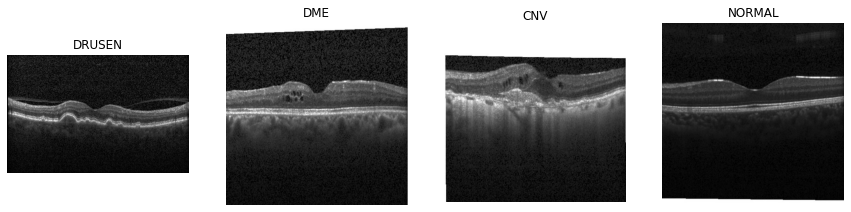

In [ ]:
# %% [code]
# Plot each type of image in the dataset

fig, ax = plt.subplots(1, 4, figsize=(15, 10))

drusen = random.choice(os.listdir(train_dir + "DRUSEN"))
drusen_image = load_img(train_dir + "DRUSEN/" + drusen)
ax[0].imshow(drusen_image)
ax[0].set_title("DRUSEN")
ax[0].axis("Off")

dme = random.choice(os.listdir(train_dir + "DME"))
dme_image = load_img(train_dir + "DME/" + dme)
ax[1].imshow(dme_image)
ax[1].set_title("DME")
ax[1].axis("Off")

cnv = random.choice(os.listdir(train_dir + "CNV"))
cnv_image = load_img(train_dir + "CNV/" + cnv)
ax[2].imshow(cnv_image)
ax[2].set_title("CNV")
ax[2].axis("Off")

normal = random.choice(os.listdir(train_dir + "NORMAL"))
normal_image = load_img(train_dir + "NORMAL/" + normal)
ax[3].imshow(normal_image)
ax[3].set_title("NORMAL")
ax[3].axis("Off")

plt.show()

In [ ]:
# %% [code]
INPUT_SHAPE = (150, 150, 3)

# %% [code]
vgg16 = tf.keras.applications.VGG16(
    include_top = False, 
    weights = 'imagenet', 
    input_tensor = None,
    input_shape = INPUT_SHAPE, 
    pooling = None, 
    classes = 1000
)

# %% [code]
vgg16.trainable = False

# %% [code]
model = tf.keras.models.Sequential([
    
    vgg16,
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

# %% [code]
model.summary()

# %% [code]
metrics_list = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4)]

# %% [code]
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics_list)

# %% [code]
train_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 100)

# %% [code]
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 16)

# %% [code]
test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(test_dir, target_size = (150, 150), class_mode = 'categorical', batch_size = 44)

# %% [code]
history = model.fit_generator(
    train_generator,
    steps_per_epoch = (83484/100),
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = (32/16),
    verbose = 1)

# %% [code]
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 64)          294976    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               25700     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 15,035,768
Trainable params: 321,080
Non-trainable params: 14,714,688
_________________________________________________________________
Found 83506 images belonging to 4 class

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
 36/834 [>.............................] - ETA: 11:12:53 - loss: 1.1089 - accuracy: 0.5198 - auc: 0.7651 - cohen_kappa: 0.2204 - f1_score: 0.3112

In [ ]:
plt.figure(figsize=(7,7))

plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure(figsize = (7,7))

plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# %% [code]
model.predict(test_generator, steps = int(968/44))

# %% [code]
model.evaluate(test_generator)

# %% [code]